# Libraries declaration

In [1]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import folium
import gtfs_kit as gk
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
import folium
from pathlib import Path
import time
import numpy as np

General configurations

In [2]:
# Ensure the OSMnx settings are optimized for your needs
ox.settings.use_cache = True
ox.settings.log_console = True


# Importing all the GTFS files

To save on the memory used, we don't import empty columns and use more efficient data types when possible.

In [3]:
dir_GTFS= "/home/lubuntu/GSDMA_2024/Tec GTFS"
print("Loading stops")
stops = pd.read_csv(dir_GTFS+"/stops.txt", usecols=['stop_id','stop_name','stop_lat','stop_lon','zone_id','location_type'])
print("Loading stop_times")
stop_times = pd.read_csv(dir_GTFS+"/stop_times.txt", dtype={'service_id':'category',
                                                            'pickup_type':'category',
                                                            'drop_off_type':'category',
                                                            'stop_sequence':'int8',
                                                           'departure_time':'string',
                                                           'arrival_time':'string'}
                        )#,parse_dates=["arrival_time", "departure_time"], date_format="%H:%M")
stop_times['arrival_time']=pd.to_timedelta(stop_times['arrival_time'])
stop_times['departure_time']=pd.to_timedelta(stop_times['departure_time'])

print("Loading trips")
trips = pd.read_csv(dir_GTFS+"/trips.txt", dtype={'service_id':'category',
                                                  'trip_short_name':'category',
                                                  'direction_id':'int8'})
print("Loading shapes")
shapes = pd.read_csv(dir_GTFS+"/shapes.txt", dtype={'shape_id':'category',
                                                    'shape_pt_sequence':'uint32'})
print("Loading routes")
routes = pd.read_csv(dir_GTFS+"/routes.txt", usecols=['route_id','agency_id','route_short_name','route_long_name','route_type'],
                    dtype={'route_type':'uint8',
                          'agency_id':'category'})
#print("Loading agency")
#agency = pd.read_csv(dir_GTFS+"/agency.txt")
print("Loading calendar")
calendar = pd.read_csv(dir_GTFS+"/calendar.txt",dtype={'monday':'boolean',
                                                      'tuesday':'boolean',
                                                      'wednesday':'boolean',
                                                      'thursday':'boolean',
                                                      'friday':'boolean',
                                                      'saturday':'boolean',
                                                      'sunday':'boolean'},
                      parse_dates=["start_date", "end_date"], date_format="%Y%m%d")
#print("Loading calendar_dates")
#calendar_dates = pd.read_csv(dir_GTFS+"/calendar_dates.txt", dtype={'exception_type':'uint8'}, parse_dates=["date"], date_format="%Y%m%d")

Loading stops
Loading stop_times
Loading trips
Loading shapes
Loading routes
Loading calendar


Some buses arrival and departure times are above 24 hours (Ex: 24:03:00). They indicate that the bus trip started the previous day and is still considered as active even if it is not today.
To handle those times, the columns 'departure_time' and 'arrival_time' are not stored as datetime but as timedelta.

In [4]:
stop_times[stop_times['arrival_time']>pd.to_timedelta('24:00:00')]#7645 stops after midnight

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type
466938,41591058-L_PA_2024-24_SP_VA-Sem-Vac-30-0000100,1 days 00:03:00,1 days 00:03:00,LaAbush*,1,0,0
466939,41591058-L_PA_2024-24_SP_VA-Sem-Vac-30-0000100,1 days 00:06:00,1 days 00:06:00,LaAelis2,2,0,0
466940,41591058-L_PA_2024-24_SP_VA-Sem-Vac-30-0000100,1 days 00:07:00,1 days 00:07:00,LaApost2,3,0,0
466941,41591058-L_PA_2024-24_SP_VA-Sem-Vac-30-0000100,1 days 00:09:00,1 days 00:09:00,LaAmise2,4,0,0
466942,41591058-L_PA_2024-24_SP_VA-Sem-Vac-30-0000100,1 days 00:11:00,1 days 00:11:00,LaAhaup2,5,0,0
...,...,...,...,...,...,...,...
5251846,45163517-L_PA_2024-24_LG_DI-Dimanche-11,1 days 00:08:00,1 days 00:08:00,Lheloti1,32,0,0
5251847,45163517-L_PA_2024-24_LG_DI-Dimanche-11,1 days 00:09:00,1 days 00:09:00,Lhehoux1,33,0,0
5251848,45163517-L_PA_2024-24_LG_DI-Dimanche-11,1 days 00:09:00,1 days 00:09:00,Lheneuv1,34,0,0
5251849,45163517-L_PA_2024-24_LG_DI-Dimanche-11,1 days 00:10:00,1 days 00:10:00,Lhecarc1,35,0,0


# Converting the dataframes to geodataframes
## Stops

In [6]:
geometry=gpd.points_from_xy(stops['stop_lon'], stops['stop_lat'], z=None, crs='epsg:4326')
geo_stops=gpd.GeoDataFrame(data=stops, geometry=geometry)
#geo_stops.sample(n=30).plot()
del stops

NameError: name 'stops' is not defined

## Shapes

In [7]:
geometry=gpd.points_from_xy(shapes['shape_pt_lon'], shapes['shape_pt_lat'], z=None, crs='epsg:4326')
geo_shapes=gpd.GeoDataFrame(data=shapes, geometry=geometry)
#geo_shapes.sample(50).plot()
del shapes

In [8]:
#Sort the lines by id and Sequence so they are ordered
geo_shapes_sorted = geo_shapes.sort_values(by=['shape_id', 'shape_pt_sequence'])

#Group the points by 'route'
lines = geo_shapes_sorted.groupby('shape_id', observed=True).apply(lambda x: LineString(x.geometry.tolist()))
lines=lines.reset_index()
lines = gpd.GeoDataFrame(data=lines['shape_id'], geometry=lines[0], crs=geo_shapes.crs)
#lines.sample(20).explore()
del geo_shapes
del geo_shapes_sorted

/tmp/ipykernel_3625/1013893770.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lines = geo_shapes_sorted.groupby('shape_id', observed=True).apply(lambda x: LineString(x.geometry.tolist()))


# Functions

In [10]:
def filter_bus_stops(geo_stops, center_gdf, radius=3000):
    """
   Filter the bus stops within a given radius of the starting point.
    """
    
    # Buffer around the center point (in meters)
    center_buffer = center_gdf.to_crs(epsg=3812).buffer(radius).to_crs(epsg=4326)#4326
    
    # Filter stops within the buffer
    filtered_stops = geo_stops[geo_stops.geometry.within(center_buffer.iloc[0])]
    
    return filtered_stops

In [11]:
# 2. Calculate shortest paths to bus stops
def calculate_shortest_paths_to_stops(graph, start_point, bus_stops):
    """
    Calculate shortest paths from the start point to each bus stop.
    """
    start_node = ox.distance.nearest_nodes(graph, start_point[1], start_point[0])
    paths = []

    for _, stop in bus_stops.iterrows():
        stop_coords = (stop.geometry.y, stop.geometry.x)
        stop_node = ox.distance.nearest_nodes(graph, stop_coords[1], stop_coords[0])
        try:
            shortest_path = nx.shortest_path(graph, source=start_node, target=stop_node, weight="length")
            path_length = sum(nx.get_edge_attributes(graph, "length").get((shortest_path[i], shortest_path[i+1], 0), 0) for i in range(len(shortest_path) - 1))
            paths.append({"stop_id": stop.stop_id, "path": shortest_path, "length": path_length,"stop_point":stop_node})
            #print(f"The length of the shortest path is {path_length:.2f} meters.")
        except nx.NetworkXNoPath:
            # Skip if there's no path
            continue
    
    return paths

In [12]:
# 3. Plot the star graph
def plot_star_graph(graph, start_point, paths, bus_stops):
    """
    Plot the graph with shortest paths to bus stops.
    """
    
    # Initialize a folium map centered at the start point
    m = folium.Map(location=start_point, zoom_start=14)
    
    # Add the graph edges to the map
    for u, v, data in graph.edges(data=True):
        if "geometry" in data:
            coords = [(lat, lon) for lon, lat in data["geometry"].coords]
        else:
            coords = [(graph.nodes[u]["y"], graph.nodes[u]["x"]), (graph.nodes[v]["y"], graph.nodes[v]["x"])]
        folium.PolyLine(coords, color="gray", weight=1).add_to(m)
    
    # Add the start point marker
    folium.Marker(location=start_point, popup="Start", icon=folium.Icon(color="green")).add_to(m)
    
    # Add bus stops and paths
    for path_info in paths:
        stop_id = path_info["stop_id"]
        path = path_info["path"]
        stop = bus_stops[bus_stops.stop_id == stop_id].iloc[0]
        
        # Add path to map
        path_coords = [(graph.nodes[node]["y"], graph.nodes[node]["x"]) for node in path]
        folium.PolyLine(path_coords, color="red", weight=2).add_to(m)
        
        # Add bus stop marker
        stop_coords = (stop.geometry.y, stop.geometry.x)
        folium.Marker(location=stop_coords, popup=f"Stop ID: {stop_id}", icon=folium.Icon(color="blue")).add_to(m)
    
    # Return the map
    return m

In [13]:
def create_gdf_with_paths(graph, start_point, paths, bus_stops):
    """
    Create a GeoDataFrame with the start point, bus stops, and paths.
    """
    # Start point as a geometry
    start_point_geom = Point(start_point[1], start_point[0])
    
    # Create a list of all nodes (start point + bus stops)
    all_nodes = [start_point_geom]
    all_paths = []

    for path_info in paths:
        stop_id = path_info["stop_id"]
        path = path_info["path"]
        stop_point = path_info["stop_point"]  # Correctly access stop_point

        # Create the path geometries (connecting the nodes)
        path_coords = [(graph.nodes[node]["x"], graph.nodes[node]["y"]) for node in path]
        for coords in path_coords:
            all_nodes.append(Point(coords))

        # Add the stop point to the nodes list
        all_nodes.append(stop_point)
    
    # Create a GeoDataFrame with the 'geometry' column
    gdf_nodes = gpd.GeoDataFrame(
        {'geometry': all_nodes}
    )
    
    # Set the CRS to 'EPSG:4326' after geometry is assigned
    gdf_nodes.set_crs("EPSG:4326", allow_override=True, inplace=True)
    
    # Add the type of node (start, path, stop)
    gdf_nodes['type'] = ['start'] + ['path'] * (len(all_nodes) - 2) + ['stop']
    
    return gdf_nodes


In [14]:
def compute_walk_time(A_stop, B_stop):
    walk_speed=4#km/h
    #For the moment, I divide the distance between them by 4km/h 
    #In the future, we will use the length of the shortest walkable path between the points 

    #The stops are projected in the Belgian Lambert 2008 coordinates system (crs=3812) to have accurate distances
    if(type(B_stop)==gpd.geodataframe.GeoDataFrame):
        B_stop=B_stop.head(1)
        A_stop=A_stop.head(1)
    birdfly_dist=A_stop.distance(B_stop, align=False)
    walk_time=birdfly_dist/(1000*walk_speed/60)#walking time in minutes (float)
    #walk_time=walk_time.mean()#If several stops have the same name, take the average of their walking distance
    walk_time=pd.to_timedelta(walk_time,unit='min')#Converted to TimeDelta
    return walk_time

In [15]:
def find_next_stops(best_arrival_time, active_trips, active_stop_times, cur_stop_id, cur_time):
    walk_range=1000#Max length in meters between the current stop and the other stops reached by foot
    
    #walk_time=compute_walk_time(arrival_stop, cur_stop)
    #Extract trips stopping by the current bus stop that are active
    #print(cur_time)
    cur_stop_times=active_stop_times[((active_stop_times['stop_id'].isin(cur_stop_id))&
                                     (active_stop_times['departure_time']>cur_time)&
                                     (active_stop_times['departure_time']<(best_arrival_time))
                                     #(active_stop_times[trip_id].isin(active_trips_id))
                                      )].sort_values('departure_time')
#    cur_stop_times=active_stop_times.query("(stop_id.isin(@cur_stop_id))"
#                                    +"&(departure_time>@cur_time)"
#                                    #+"&(trip_id.isin(@active_trips_id))"
#                                     ).sort_values('departure_time')
    
    #Extract the other stops that can be reached with the trips
    other_stops_times=[]
    for row in cur_stop_times.itertuples(index=False):
        departure_seq=int(row.stop_sequence)
        other_stops_time=active_stop_times[((active_stop_times['trip_id']==row.trip_id)
                                      &(active_stop_times['arrival_time']<(cur_time+walk_time))
                                      &(active_stop_times['stop_sequence']>departure_seq)
                                     )]
        other_stops_times.append(other_stops_time)
        #active_stop_times=active_stop_times[~active_stop_times.eq(other_stops_time,axis=0).all(axis=1)]
        #print(row.departure_time, end='\r')

    #Add the stops reachable by foot
    cur_stop=geo_stops[geo_stops['stop_id'].isin(cur_stop_id)]
    meas_geo_stops=geo_stops.to_crs(3812)
    walked_stops=meas_geo_stops[meas_geo_stops.within(cur_stop.to_crs(3812).buffer(1000).geometry.iloc[0])]
    walked_stop_times=pd.DataFrame(columns=stop_times.columns)
    walked_stop_times['stop_id']=walked_stops['stop_id']
    walked_stop_times['trip_id']='walking'
    walked_stop_times['arrival_time']=cur_time+compute_walk_time(walked_stops, cur_stop.to_crs(3812).iloc[0].geometry)
    walked_stop_times['departure_time']=walked_stop_times['arrival_time']
    walked_stop_times['stop_sequence']=1
    walked_stop_times['pickup_type']=0
    walked_stop_times['drop_off_type']=0
    
    #print(walked_stop_times)
    if(walked_stop_times.size>0):
        other_stops_times.append(walked_stop_times)
    
    if(len(other_stops_times)>0):
        other_stops_times=pd.concat(other_stops_times)
    else:
        print("No next stops found")
        return pd.DataFrame()
    return other_stops_times

In [28]:
def explore_node(geo_stops, active_trips, active_stop_times, found_stop_times, best_arrival_time, best_path, cur_stop_time):
    num_trans=cur_stop_time['number_trips']+1
    #print(cur_stop_time[['stop_id','final_arrival_time', 'intermediary_stops']])
    num_trans=num_trans.iloc[0]
    max_trans=3
    if(num_trans>max_trans):
        print("Max number of transfers reached")
        return pd.DataFrame(), best_arrival_time, best_path
    cur_stop_id=cur_stop_time['stop_id']#pd.Series(row.stop_id)
    cur_time=cur_stop_time['arrival_time'].iloc[0]#row.arrival_time
    
    #Extract the stops directly linked to the current stop
    #print(previous_stops)
    other_stops_times=find_next_stops(best_arrival_time, active_trips, active_stop_times, cur_stop_id, cur_time)

    if(other_stops_times.size>0):
        
        #print(previous_stops)
        other_stops_times['number_trips']=num_trans
        #print(cur_stop_time)
        other_stops_times['intermediary_stops']=other_stops_times.apply(lambda x:UpdatePath(cur_stop_time,x),axis=1)
        
        #Compute the proximity of the stops discovered from the arrival stop
        other_stops=geo_stops.merge(other_stops_times.reset_index(), on='stop_id',how='right', )
        new_walk_times=compute_walk_time(other_stops.to_crs(3812), arrival_stop.to_crs(3812).iloc[0].geometry)#TODO: Optimize: store arrival_stop in crs 3812
        other_stops['final_arrival_time']=other_stops['arrival_time']+new_walk_times
        other_stops=other_stops.set_index('index')
        new_best_arrival_time=other_stops['final_arrival_time'].min()
        if(new_best_arrival_time<best_arrival_time):
            #Update the current best path
            previous_stops=other_stops[other_stops['final_arrival_time']==new_best_arrival_time].copy()
            best_path=previous_stops['intermediary_stops'].iloc[0]
            best_path.append((arrival_stop['stop_id'].iloc[0],'walking'))
            best_arrival_time=new_best_arrival_time

        #TODO: Filter out the stops from which you would arrive later at the arrival stop than the best path even in bus in bird fly
        other_stops_times['final_arrival_time']=other_stops['final_arrival_time']
        other_stops_times=other_stops_times[other_stops_times['arrival_time']<best_arrival_time]
    else:
        return pd.DataFrame(), best_arrival_time, best_path
    return other_stops_times, best_arrival_time, best_path
def UpdatePath(previous_stop, stop):
    #print(stop)
    cur_stop_id=previous_stop['stop_id']
    #Update the path going to these stops
    previous_stops=previous_stop.loc[:,'intermediary_stops'].iloc[0].copy()#row.intermediary_stops[:]
    previous_stops.append((cur_stop_id.iloc[0], stop['trip_id']))
    return previous_stops#TODO: also include the trips used (or walking)

# Main process

## Graph of the shortest walkable paths

In [46]:
# Def/home/lubuntu/.local/share/jupyter/runtimeine the starting location
departure_date="2024-11-05"
departure_time="08:00:00"
departure_stop_name="MONS Brisselot"#"MONS Place de Flandre"#
arrival_stop_name="SOIGNIES Place du Jeu de Balle"

radius = 5000  # For graph creation
bus_stop_radius = 3000  # For filtering stops
    
# Path to GTFS stops.txt file
gtfs_stops_file = 'Tec GTFS/stops.txt' # Replace with your GTFS file path
    
# Get the center point
start_point = ox.geocode(departure_stop_name)
    # Create a GeoDataFrame for the center point
start_gdf = gpd.GeoDataFrame(
    {"geometry": [Point(start_point[1], start_point[0])]},
    crs="EPSG:4326",
)
# Create the graph
graph = ox.graph_from_point(start_point, dist=radius, network_type="walk")
print("Graph created")
# Filter bus stops within the specified radius
filtered_stops = filter_bus_stops(geo_stops, start_gdf, radius=bus_stop_radius)
print("Bus stops retrieved")
# Calculate shortest paths to bus stops
paths = calculate_shortest_paths_to_stops(graph, start_point, filtered_stops)
print("Shortests paths found")
print("Plotting...")
# Plot the star graph
star_map = plot_star_graph(graph, start_point, paths, filtered_stops)
#star_map.save("star_graph_map.html")
star_map

/home/lubuntu/.local/share/virtualenvs/GSDMA_2024-IfVh60CW/lib/python3.9/site-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


Graph created
Bus stops retrieved


KeyboardInterrupt: 

## Shortests bus paths

In [ ]:
#Find the bus stops with a given name within 
geo_stops[geo_stops['stop_name'].str.contains('Kennedy')].iloc[0:10]

In [47]:
walking_range = 1000#The algorithm considers that bus stops closer than that value in meters can be linked by walking

start_time = time.time()
#Extract the stops and the stop_id's
departure_stop=geo_stops.query("stop_name==@departure_stop_name")
arrival_stop=geo_stops.query("stop_name==@arrival_stop_name")

arrival_stop_id=arrival_stop['stop_id']
departure_stop_id=departure_stop['stop_id']

#The walking time between the departure and the arrival is computed
walk_time=compute_walk_time(departure_stop.to_crs(3812), arrival_stop.to_crs(3812))
walk_time=walk_time.mean()

departure_time=pd.to_timedelta(departure_time)
best_arrival_time=departure_time+walk_time
print(f"First arrival time: {best_arrival_time}")
best_path=[('walking', 'arrival_stop_name')]

#Find the schedule of the day
week_day=pd.Timestamp(departure_date).day_name().lower()
active_services=calendar.query("(start_date<=@departure_date)&(@departure_date<=end_date)")
active_services=active_services[active_services[week_day]]
active_trips=trips[trips['service_id'].isin(active_services['service_id'])]
active_trips_id=active_trips['trip_id']
active_stop_times=stop_times[stop_times['trip_id'].isin(active_trips_id)]
active_stop_times=active_stop_times[active_stop_times['arrival_time']<best_arrival_time]

#Find the stoptimes of the departure stop
found_stop_times=active_stop_times[((active_stop_times['stop_id'].isin(departure_stop_id))&
                                     (active_stop_times['departure_time']>departure_time)&
                                     (active_stop_times['departure_time']<(best_arrival_time))
                                     #(active_stop_times[trip_id].isin(active_trips_id))
                                      )].sort_values('departure_time')
found_stop_times.loc[:, "intermediary_stops"] = [[(departure_stop_id.iloc[0],'Already here')]] * len(found_stop_times)
found_stop_times['final_arrival_time']=best_arrival_time

##Add the stops reachable by foot from the departure point
#meas_geo_stops=geo_stops.to_crs(3812)
#walked_stops=meas_geo_stops[meas_geo_stops.within(start_gdf.to_crs(3812).buffer(walking_range).geometry.iloc[0])]
#walked_stop_times=pd.DataFrame(columns=stop_times.columns)
#walked_stop_times['stop_id']=walked_stops['stop_id']
#walked_stop_times['trip_id']='walking'
#walked_stop_times['arrival_time']=departure_time+compute_walk_time(walked_stops, start_gdf.to_crs(3812).iloc[0].geometry)
#walked_stop_times['departure_time']=walked_stop_times['arrival_time']
#walked_stop_times['stop_sequence']=1
#walked_stop_times['pickup_type']=0
#walked_stop_times['drop_off_type']=0
#walked_stop_times.loc[:, "intermediary_stops"] = [[(departure_stop_id.iloc[0],'walking')]] * len(walked_stop_times) 
#found_stop_times=pd.concat([found_stop_times,walked_stop_times])

found_stop_times['number_trips']=0
found_stop_times['explored']=False
new_stop_times=found_stop_times[found_stop_times['explored']==False]#The found stops not already explored

#other_stops_times=find_next_stops(best_arrival_time, active_trips, active_stop_times, departure_stop_id, departure_time)

#found_stop_times['explored']=True
#other_stops_times['number_trips']=1
#other_stops_times.loc[:, "intermediary_stops"] = [[departure_stop_id.iloc[0]]] * len(other_stops_times) #other_stops_times['intermediary_stops']=''
##TODO: Add other stops within walkable distance
#other_stops_times=other_stops_times.sort_values('arrival_time').drop_duplicates('stop_id')#We keep only the earliest arrival time to a stop.
#other_stops_times['explored']=False
#
##Compare the walking time from the new stops
#other_stops=geo_stops.merge(other_stops_times.reset_index(), on='stop_id',how='right', )
#new_walk_times=compute_walk_time(other_stops.to_crs(3812), arrival_stop.to_crs(3812).iloc[0].geometry)
#other_stops['final_arrival_time']=other_stops['arrival_time']+new_walk_times
#other_stops=other_stops.set_index('index')
#new_best_arrival_time=other_stops['final_arrival_time'].min()
#if(new_best_arrival_time<best_arrival_time):
#    print(f"New best arrival time: {new_best_arrival_time}")
#    best_path=[(departure_stop_id.iloc[0], 'w')]
#    best_arrival_time=new_best_arrival_time
#    #Drop the scheduled stops later than the current best arrival time 
#    active_stop_times=active_stop_times[active_stop_times['arrival_time']<best_arrival_time]

#other_stops_times['final_arrival_time']=other_stops['final_arrival_time']
#found_stop_times=pd.concat([found_stop_times,other_stops_times])
#found_stop_times=found_stop_times.sort_values('arrival_time').drop_duplicates('stop_id')#We keep only the earliest arrival time to a stop.
#found_stop_times=found_stop_times.sort_values('final_arrival_time')

#new_stop_times=found_stop_times[found_stop_times['explored']==False]#The found stops not already explored


while(new_stop_times.size>0):
    new_stop_times=found_stop_times[found_stop_times['explored']==False]#The found stops not already explored
    cur_stop_time=new_stop_times.iloc[0:1,:]

    other_stops_times, new_best_arrival_time, new_best_path=explore_node(geo_stops, active_trips, active_stop_times, found_stop_times, best_arrival_time, best_path, cur_stop_time)
    other_stops_times['explored']=False
    found_stop_times.loc[cur_stop_time.index,'explored']=True

    #Drop the scheduled stops later than the current best arrival time
    if(new_best_arrival_time<best_arrival_time):
        print(f"New best arrival time: {new_best_arrival_time}")
        best_arrival_time=new_best_arrival_time
        best_path=new_best_path
        active_stop_times=active_stop_times[active_stop_times['arrival_time']<best_arrival_time]
        found_stop_times=found_stop_times[found_stop_times['arrival_time']<best_arrival_time]

    found_stop_times=pd.concat([found_stop_times,other_stops_times])
    found_stop_times=found_stop_times.sort_values('arrival_time')
    found_stop_times=found_stop_times.drop_duplicates('stop_id')#We keep only the earliest arrival time to a stop.
    found_stop_times=found_stop_times.sort_values('final_arrival_time')
    new_stop_times=found_stop_times[found_stop_times['explored']==False]#The found stops not already explored
    print(f"{found_stop_times.shape[0]-new_stop_times.shape[0]}/{found_stop_times.shape[0]}")
end_time = time.time()
print(f"Best arrival time:{best_arrival_time}")
print(f"Best path:{best_path}")
print(f"It took {end_time-start_time} seconds to compute")

First arrival time: 0 days 12:05:53.778457758
1/49
New best arrival time: 0 days 09:33:00
2/131
3/132
Max number of transfers reached
4/132
4/134
Max number of transfers reached
5/134
Max number of transfers reached
6/134
Max number of transfers reached
7/134
8/134
9/137
Max number of transfers reached
10/137
Max number of transfers reached
11/137
Max number of transfers reached
12/137
12/138
Max number of transfers reached
13/138
Max number of transfers reached
14/138
14/139
Max number of transfers reached
15/139
Max number of transfers reached
16/139
16/140
Max number of transfers reached
17/140
Max number of transfers reached
18/140
19/141
Max number of transfers reached
20/141
20/142
Max number of transfers reached
21/142
Max number of transfers reached
22/142
22/143
Max number of transfers reached
23/143
23/143
Max number of transfers reached
24/143
Max number of transfers reached
25/143
25/145
Max number of transfers reached
26/145
Max number of transfers reached
27/145
28/145
Ma

In [79]:
geo_paths=[]
for i in range(len(best_path)):
    print(i)
    inter=best_path[i]
    inter_stop_id=inter[0]
    inter_stop=geo_stops[geo_stops['stop_id']==inter_stop_id]
    way=inter[1]
    if(way=="walking"):
        if(i==len(best_path)-1):
            print()
        else:
            next_stop_id=best_path[i+1][0]
            next_stop=geo_stops[geo_stops['stop_id']==next_stop_id]
            inter_shape=gpd.GeoDataFrame(columns=lines.columns, crs=geo_stops.crs)
            inter_shape['shape_id']='walking'
            inter_shape['geometry']=LineString([inter_stop.iloc[0].geometry, next_stop.iloc[0].geometry])
            print(inter_shape)
            geo_paths.append(inter_shape)
    elif(way=="Already here"):
        print()
    else:
        inter_trip=trips[trips['trip_id']==way]
        inter_shape_id=inter_trip['shape_id'].iloc[0]
        inter_shape=lines[lines['shape_id']==inter_shape_id]
        geo_paths.append(inter_shape)
pd.concat(geo_paths)

0

1
Empty GeoDataFrame
Columns: [shape_id, geometry]
Index: []
2
3



/tmp/ipykernel_3625/925551240.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pd.concat(geo_paths)


,shape_id,geometry
1677,H11500100,"LINESTRING (3.94165 50.45304, 3.94174 50.45313..."


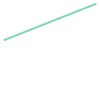

In [71]:
LineString([geo_stops.iloc[0].geometry, geo_stops.iloc[10].geometry])

In [78]:
geo_paths

[Empty GeoDataFrame
 Columns: [shape_id, geometry]
 Index: [],
        shape_id                                           geometry
 1677  H11500100  LINESTRING (3.94165 50.45304, 3.94174 50.45313...]

In [48]:
found_stop_times

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type,intermediary_stops,final_arrival_time,number_trips,explored
5338193,45184776-H_2024-H24_P2-Sem-N-3-11-0100000,0 days 09:31:00,0 days 09:31:00,H3so155a,45.0,0,0,"[(H1ms908a, Already here), (H1ms908a, walking)...",0 days 09:36:31.072196268,3.0,True
9348,walking,0 days 09:32:17.584876608,0 days 09:32:17.584876608,H3so155b,1.0,0,0,"[(H1ms908a, Already here), (H1ms908a, walking)...",0 days 09:36:33.162950634,3.0,True
9367,walking,0 days 09:30:00,0 days 09:30:00,H3so166d,1.0,0,0,"[(H1ms908a, Already here), (H1ms908a, walking)...",0 days 09:42:00.645615372,3.0,True
2634,walking,0 days 09:30:00.968198292,0 days 09:30:00.968198292,Bsoigar2,1.0,0,0,"[(H1ms908a, Already here), (H1ms908a, walking)...",0 days 09:42:00.767661420,3.0,True
2633,walking,0 days 09:30:12.167963952,0 days 09:30:12.167963952,Bsoigar1,1.0,0,0,"[(H1ms908a, Already here), (H1ms908a, walking)...",0 days 09:42:00.935803758,3.0,True
...,...,...,...,...,...,...,...,...,...,...,...
5357464,45185124-H_2024-H24_P2-Sem-N-3-11,0 days 09:28:00,0 days 09:28:00,H1al106a,45.0,0,0,"[(H1ms908a, Already here), (H1ms908a, walking)...",0 days 16:41:37.073152764,3.0,True
6872,walking,0 days 09:10:08.699246556,0 days 09:10:08.699246556,H1er109b,1.0,0,0,"[(H1ms908a, Already here), (H1ms908a, walking)...",0 days 16:42:07.783893924,3.0,True
6871,walking,0 days 09:10:29.332721448,0 days 09:10:29.332721448,H1er109a,1.0,0,0,"[(H1ms908a, Already here), (H1ms908a, walking)...",0 days 16:43:01.348900458,3.0,True
5357463,45185124-H_2024-H24_P2-Sem-N-3-11,0 days 09:28:00,0 days 09:28:00,H1al108a,44.0,0,0,"[(H1ms908a, Already here), (H1ms908a, walking)...",0 days 16:44:49.080212718,3.0,True


In [49]:
found_stop_times['departure_time']=found_stop_times['departure_time'].apply(lambda x: x.total_seconds())
found_stop_times['final_arrival_time']=found_stop_times['final_arrival_time'].apply(lambda x: x.total_seconds())
found_stop_times['arrival_time']=found_stop_times['arrival_time'].apply(lambda x: x.total_seconds())

In [50]:
geo_stops.merge(found_stop_times, how='right').sort_values('final_arrival_time').explore(column='final_arrival_time')